# Question Answering Solution

### Introduction
- **Objective**: Develop and evaluate a question-answering model using the ConvFinQA dataset.

### Data Preparation
- **Load Data**: Import the dataset.
- **Clean Data**: Handle missing values and preprocess text.

### Evaluation Metrics
- **Self-Evaluation**: The LLM will consider the likeness of its answer against the label 
- **Numeric Percentaje**: How close a numeric output is to the label


In [2]:
import json
from openai import OpenAI
import os
from dotenv import load_dotenv
import random
import pandas as pd
import re

In [3]:
with open("../../data/train_extended.json") as f:
    data = json.load(f)

#### Sampling 100 random entries for swiftness

In [ ]:
df = pd.DataFrame(random.sample(data, 100))

In [6]:
len(df['qa'].dropna())

68

#### Will take one question per document.
#### Further questions beyond the first will be ignored.

In [7]:
df['qa'] = df['qa'].fillna(df['qa_0'])
df = df.drop(['qa_0', 'qa_1'], axis=1)
len(df['qa'].dropna())

100

### Client
Working with LMStudio we can use OpenAI's python library for local models too

In [8]:
# client = OpenAI(
#     api_key = "lm-studio",  
#     base_url="http://localhost:1234/v1"
# )

load_dotenv()

client = OpenAI(
    api_key = os.getenv('SECRET_OPENAI_API_KEY'), 
)

### First approach

In [9]:
def extract_bracket_content(text):
    match = re.search(r'\[(.*?)\]$', text)
    if match:
        return match.group(1)
    return None

def single_query(doc, query, model="gpt-3.5-turbo", verbose = False):

    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """
                    You are a helpful assistant tasked with answering user queries about a page with financial data.
                    Reflect on the data provided and produce an answer.
                    Report the exact answer at the end in brackets '[]'.
                    Answer example: 
                    'From 2010 to 2014 it lasted 4 years. [4]'
                    """
            },
            {
                "role": "user",
                "content": f"""
                    USER_QUERY: {query['question']}
                    """,
            },
            {
                "role": "assistant",
                "content": f"""
                    CONTEXT_DOCUMENT: {doc}
                    """,
            }
        ],
        model=model,
    ).choices[0].message.content
    if verbose:
        return response, extract_bracket_content(response)
    else:
        return extract_bracket_content(response)

### Self-reflection and One shot
With self reflection, an a one shot instruction on how to present the output for a basic postprocessing seems to work.

In [10]:
MODEL = "gpt-3.5-turbo"

df[f'{MODEL}_answer'] = df.apply(
                            lambda row: single_query(
                                                row['join_text'],
                                                row['qa'],
                                                MODEL,
                                                verbose=True
                                                ),
                            axis = 1
                            )

In [11]:
df['qa'][0]['question']

'at january 29 , 2007 what was the percent of the estimated fair value of the goodwill to the total purchase price'

In [12]:
print(df[f'{MODEL}_answer'][0])

('To calculate the percentage of the estimated fair value of the goodwill to the total purchase price on January 29, 2007, we first need to determine the values. The estimated fair value of the goodwill on that date was $646.7 million, and the total purchase price was $2320.7 million.\nNow, to find the percentage, we can use the formula:\nPercentage = (Value of Goodwill / Total Purchase Price) * 100\nPlugging in the values:\nPercentage = ($646.7 / $2320.7) * 100\nPercentage ≈ 27.89%\nTherefore, on January 29, 2007, the percentage of the estimated fair value of the goodwill to the total purchase price was approximately 27.89%. [27.89%]', '27.89%')


In [13]:
df['qa'][0]['answer']

'27.9'

In [14]:
len(df[f'{MODEL}_answer'].dropna())

100

### Let's now try to measure it's quality with proper metrics

### SequenceMatcher

`SequenceMatcher` is a class in Python's `difflib` module that compares pairs of sequences of any type, as long as the elements are hashable. It finds the longest contiguous matching subsequence that contains no "junk" elements (e.g., blank lines or whitespace). This process is applied recursively to the left and right pieces of the matching subsequence.

### Jaccard Similarity Coefficient

The Jaccard similarity coefficient (Jaccard index) measures the similarity and diversity of sample sets. It is defined as the size of the intersection divided by the size of the union of the sample sets:

$$ \text{Jaccard Similarity} = \frac{|A \cap B|}{|A \cup B|} $$

The Jaccard similarity ranges from 0 to 1. A value closer to 1 indicates higher similarity, while 0 means no common elements.

In [15]:
from difflib import SequenceMatcher

def sequence_matcher(a, b):
    if a is not None and b is not None:
        return SequenceMatcher(None, a, b).ratio()
    else:
        return None

def jaccard_similarity(a, b):
    if a is not None and b is not None:
        intersection = len(set(a).intersection(set(b)))
        union = len(set(a).union(set(b)))
        return intersection / union
    else:
        return None


### Numeric Percentage Closeness

Numeric percentage closeness measures how similar two numbers are. It is calculated using the following steps:

1. **Calculate the Difference**: Compute the absolute difference between the label and the answer.
   ```python
   difference = abs(label_num - answer_num)
   ```

2. **Calculate the Percentage Error**: Normalize the difference by dividing it by the sum of the label and answer, plus a small epsilon to avoid division by zero.
   ```python
   percentage_error_normalized = (difference / (label_num + answer_num + epsilon))
   ```

This metric helps in evaluating the accuracy of numerical predictions by showing how close the predicted value is to the actual value.


In [ ]:
import re

def extract_number(text):
    # Remove commas from the text
    text = text.replace(',', '')
    # Find all numbers in the text, including decimals
    numbers = re.findall(r'\d+\.\d+|\d+', text)
    # Convert them to floats
    numbers = [float(num) for num in numbers]
    # Return the first number found, or None if no numbers are found
    return numbers[0] if numbers else None

def compare_numbers(a, b):
    label_num = None
    answer_num = None
    if a is not None and b is not None:
        # Extract numbers from both texts
        label_num = extract_number(b)
        answer_num = extract_number(a)
    
    # Check if both numbers are found
    if label_num is not None and answer_num is not None:
        # Define a small epsilon value
        epsilon = 1e-10
        # Calculate the absolute difference between the two numbers
        difference = abs(label_num - answer_num)
        # Calculate the percentage error
        percentage_error_normalized = (difference / (label_num + answer_num + epsilon))
        return 1 - percentage_error_normalized
    else:
        return None

### LLM Model Self-Evaluation

LLM model self-evaluation involves the model assessing its own performance. This can be done by comparing the model's predictions with the ground truth and calculating various metrics such as accuracy, precision, recall, and F1 score. The goal is to understand how well the model is performing and identify areas for improvement.

In [34]:
def self_evaluation(
                query,
                a,
                b,
                client,
                model="gpt-3.5-turbo",
                verbose=False
                ):
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """You are a helpful agent that will evaluate financial answers from a LLM.
                Given the USER_QUERY, compare CORRECT_ANSWER against LLM_ANSWER.
                Provide only a 1 if LLM_ANSWER is correct.
                Provide a number between 0 and 1 if LLM_ANSWER is partially correct. 
                Provide a 0 if LLM_Answer is wrong.
                """
            },
            {
                "role": "user",
                "content": f"""
                    USER_QUERY: {query}
                    CORRECT_ANSWER: {a}
                    LLM_ANSWER: {b}
                    """,
            },
            {
                "role": "assistant",
                "content": f"""
                    Write exclusively a number as your output. Eg: 1
                    """,
            }
        ],
        model=model,
    ).choices[0].message.content
    if verbose:
        return response, extract_number(response)
    return extract_number(response)


In [39]:
df[f"{MODEL}_self_ev"] = df.apply(lambda row: self_evaluation(row['qa']['question'], row[f'{MODEL}_answer'][1], row['qa']['answer'], client), axis=1)
df[f"{MODEL}_numeric_perc"] = df.apply(lambda row: compare_numbers(row[f'{MODEL}_answer'][1], row['qa']['answer']), axis=1)
df[f"{MODEL}_jaccard_sim"] = df.apply(lambda row: jaccard_similarity(row[f'{MODEL}_answer'][1], row['qa']['answer']), axis=1)
df[f"{MODEL}_sequence"] = df.apply(lambda row: sequence_matcher(row[f'{MODEL}_answer'][1], row['qa']['answer']), axis=1)

## Analysis

In [41]:
df.head()

,pre_text,post_text,filename,table_ori,table,id,annotation,join_text,input_tokens,qa,gpt-3.5-turbo_answer,gpt-3.5-turbo_numeric_perc,gpt-3.5-turbo_jaccard_sim,gpt-3.5-turbo_sequence,gpt-3.5-turbo_self_ev
0,"[icos corporation on january 29 , 2007 , we ac...",[1this intangible asset will be amortized over...,LLY/2008/page_45.pdf,"[[Cash and short-term investments, $197.7], [D...","[[cash and short-term investments, $ 197.7], [...",Double_LLY/2008/page_45.pdf,{'amt_table': '<table class='wikitable'><tr><t...,"icos corporation on january 29 , 2007 , we acq...",1004,"{'question': 'at january 29 , 2007 what was th...",(To calculate the percentage of the estimated ...,0.999821,0.666667,0.800000,1.0
1,[citigroup 2019s repurchases are primarily fro...,[goodwill goodwill represents an acquired comp...,C/2009/page_141.pdf,"[[In millions of dollars, 2009, 2008], [Balanc...","[[in millions of dollars, 2009, 2008], [balanc...",Single_C/2009/page_141.pdf-4,{'amt_table': '<table class='wikitable'><tr><t...,citigroup 2019s repurchases are primarily from...,1291,{'question': 'what was the percentage change i...,(To calculate the percentage change in the rep...,0.999696,0.375000,0.545455,1.0
2,"[zimmer biomet holdings , inc ., and subsidiar...",[we have also recognized other employee termin...,ZBH/2017/page_50.pdf,"[[, Employee Termination Benefits, Contract Te...","[[, employee termination benefits, contract te...",Single_ZBH/2017/page_50.pdf-2,{'amt_table': '<table class='wikitable'><tr><t...,"zimmer biomet holdings , inc .\nand subsidiari...",1156,{'question': 'what was the percentage change i...,(The percentage change in the allowance for do...,0.990199,0.600000,0.666667,0.5
3,[masco corporation notes to consolidated finan...,"[investments ., with respect to the company 20...",MAS/2012/page_92.pdf,"[[, 2012, 2011], [Balance at January 1, $102, ...","[[, 2012, 2011], [balance at january 1, $ 102,...",Single_MAS/2012/page_92.pdf-1,{'amt_table': '<table class='wikitable'><tr><t...,masco corporation notes to consolidated financ...,688,{'question': 'what was the percent of the chan...,(To calculate the percent change in the compan...,0.999681,0.571429,0.727273,1.0
4,[2015 compared to 2014 mfc 2019s net sales in ...,[2016 compared to 2015 rms 2019 net sales in 2...,LMT/2016/page_50.pdf,"[[, 2016, 2015, 2014], [Net sales, $13,462, $9...","[[, 2016, 2015, 2014], [net sales, $ 13462, $ ...",Single_LMT/2016/page_50.pdf-4,{'amt_table': '<table class='wikitable'><tr><t...,2015 compared to 2014 mfc 2019s net sales in 2...,1008,{'question': 'what is the growth rate of opera...,(To calculate the growth rate of operating exp...,0.050503,0.107143,0.038462,0.0


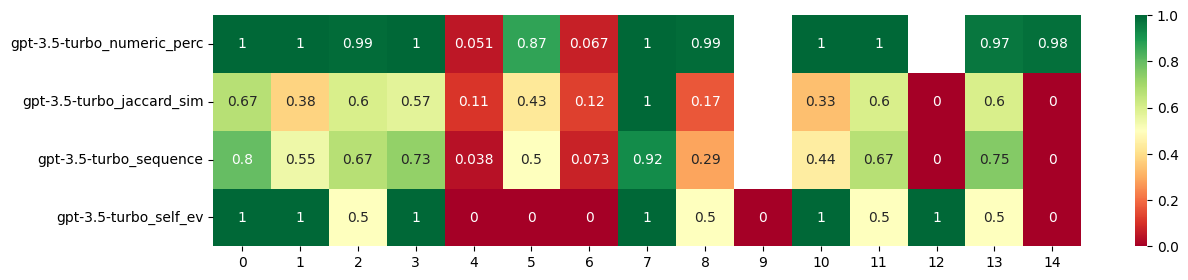

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

transposed_corpus = df.iloc[:15, -4:].T
plt.figure(figsize=(14, 3))
sns.heatmap(transposed_corpus, cmap='RdYlGn', vmin=0, vmax=1, annot=True)

# Show the plot
plt.show()

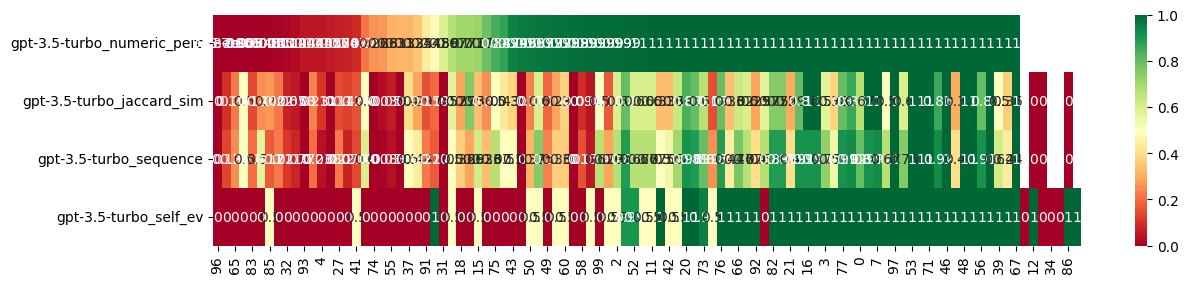

In [45]:
sorted_df = df.sort_values(by=f'{MODEL}_numeric_perc')


transposed_corpus = sorted_df.iloc[:, -4:].T
plt.figure(figsize=(14, 3))
sns.heatmap(transposed_corpus, cmap='RdYlGn', vmin=0, vmax=1, annot=True)

# Show the plot
plt.show()

In [21]:
i = 51

print('Query: ' + df.iloc[i]['qa']['question'])
print('Label:                ' + df.iloc[i]['qa']['answer'])
print(f'{MODEL} answer: ' + df.iloc[i]['gpt-3.5-turbo_answer'][1])
print('\n')
print(f'{MODEL} reflection: \n' + df.iloc[i]['gpt-3.5-turbo_answer'][0])

Query: assuming 4 inventory turns per year , what would q12012 cash flow be from the receivables balance on december 31 , 2011 , in billions?
Label:                4.7
gpt-3.5-turbo answer: Calculating the cash flow from the receivables balance on December 31, 2011, for the first quarter of 2012 requires additional specific information like the accounts receivable turnover rate and average receivables balance.


gpt-3.5-turbo reflection: 
In order to calculate the cash flow from the receivables balance on December 31, 2011, for the first quarter of 2012, we would first need to determine the average accounts receivable balance for the period. Given the information provided in the financial data, we would require further details or calculations to accurately estimate the cash flow from the receivables balance. If you provide additional specific numbers or percentages related to the accounts receivable turnover rate and average receivables balance, we can assist in calculating the cash fl

In [46]:
df.describe()

,input_tokens,gpt-3.5-turbo_numeric_perc,gpt-3.5-turbo_jaccard_sim,gpt-3.5-turbo_sequence,gpt-3.5-turbo_self_ev
count,100.000000,9.300000e+01,96.000000,96.000000,100.000000
mean,877.220000,7.305324e-01,0.449257,0.501788,0.517500
std,252.520169,3.914613e-01,0.332699,0.341402,0.457727
min,235.000000,9.111617e-08,0.000000,0.000000,0.000000
25%,726.000000,3.457052e-01,0.156883,0.200000,0.000000
50%,897.500000,9.901990e-01,0.375000,0.500000,0.500000
75%,1043.250000,9.996033e-01,0.750000,0.822222,1.000000
max,1529.000000,1.000000e+00,1.000000,1.000000,1.000000


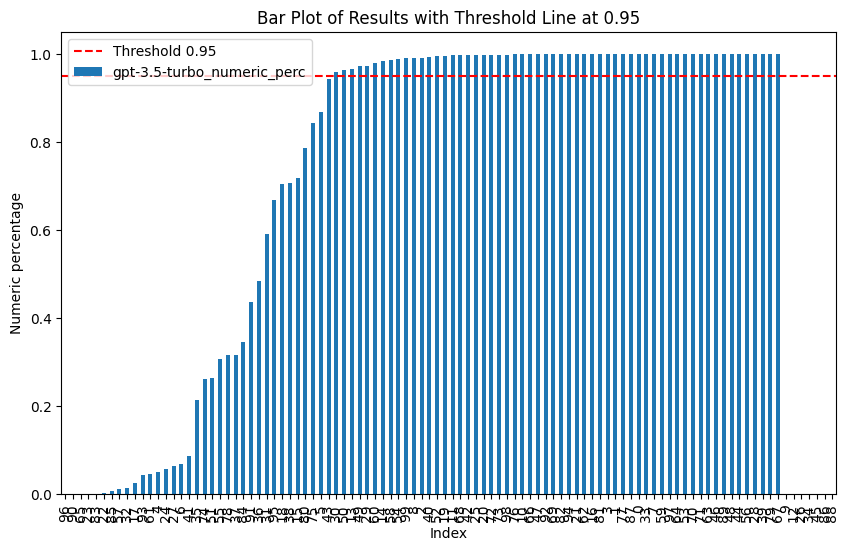

In [47]:
# Create a bar plot
plt.figure(figsize=(10, 6))

sorted_df[f'{MODEL}_numeric_perc'].plot(kind='bar')

# Add a horizontal line at y=0.95
plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold 0.95')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Numeric percentage')
plt.title('Bar Plot of Results with Threshold Line at 0.95')
plt.legend()

# Show the plot
plt.show()

In [48]:
# Filter the DataFrame to get rows where the "results" column is greater than 0.95
filtered_5_df = df[df[f'{MODEL}_numeric_perc'] > 0.95]
filtered_3_df = df[df[f'{MODEL}_numeric_perc'] > 0.97]
filtered_1_df = df[df[f'{MODEL}_numeric_perc'] > 0.99]

# Display the filtered DataFrame
print(f"Correct answers with a 5% confidence range: {len(filtered_5_df)}")
print(f"Correct answers with a 3% confidence range: {len(filtered_3_df)}")
print(f"Correct answers with a 1% confidence range: {len(filtered_1_df)}")

Correct answers with a 5% confidence range: 58
Correct answers with a 3% confidence range: 55
Correct answers with a 1% confidence range: 47


### Conclusions

Most queries and answers involve specific numeric values or percentages, making Numeric Percentage Closeness and self-evaluation the most appropriate metrics. Other matching metrics are less effective in this context.

While the context is accurate, answers often require reflection and calculations, leading to slight variations (e.g., decimals or approximations) and format differences. There is also a risk of incorrect evaluation due to the verbosity of the models.

Nevertheless, 58 out of 100 answers fall within a 5% range of numeric closeness.